In [54]:
import matplotlib
import numpy as np
from os import listdir
from os.path import isfile, join
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [70]:
#only for ratelimited
def extractBandwidth(fpath):
    data = []
    with open(fpath,'r') as f:
        for line in f.readlines():
            tmpstring = line.lstrip()
            if tmpstring == '':
                continue
            elif tmpstring[0].isdigit():
                #print(line)
                tmpstrings = tmpstring.split()
                msg_size = tmpstrings[0]
                burst_size = tmpstrings[1]
                avg_bw = tmpstrings[2]
                #GB to MB
                avg_bw = 1000 * float(avg_bw)
                kmsg_sec = tmpstrings[3]
                data += [(msg_size, burst_size, avg_bw)]
        return data
    print("No conforming data found in {}".format(f))
    return None

def extractBandwidthStd(fpath):
    data = []
    with open(fpath,'r') as f:
        for line in f.readlines():
            tmpstring = line.lstrip()
            if tmpstring == '':
                continue
            elif tmpstring[0].isdigit():
                #print(line)
                tmpstrings = tmpstring.split()
                msg_size = tmpstrings[0]
                avg_bw = tmpstrings[1]
                #GB to MB
                avg_bw = 1000 * float(avg_bw)
                data += [(msg_size, avg_bw)]
        return data
    print("No conforming data found in {}".format(f))
    return None

def extractData(fpath):
    bw = extractBandwidth(fpath)
    if bw == None:
        return None
    return(test_type, distance, msg_sz, q_depth, rate_limit)


In [56]:
basepath = "../results/summit/device/rate-limited/nvshmem/02-26-20.22.00.41/device/"
mypaths = [join(basepath,"shmem_get_bw_ratelimit-12500.out"),
           join(basepath,"shmem_get_bw_ratelimit-6250.out"),
           join(basepath,"shmem_get_bw_ratelimit-3125.out"),
           join(basepath,"shmem_get_bw_ratelimit-1562.out")]

In [57]:
dfs = []
for mypath in mypaths:
    dftmp = pd.DataFrame(extractBandwidth(mypath), columns=["MsgSize", "BurstSize", "AvgBW"])
    dftmp["RorW"] = "read"
    dftmp["Distance"] = "xnode"
    if "12500" in mypath:
        dftmp["RateLimit"] = 12500
    elif "6250" in mypath:
        dftmp["RateLimit"] = 6250
    elif "3125" in mypath:
        dftmp["RateLimit"] = 3125
    elif "1562" in mypath:
        dftmp["RateLimit"] = 1562
    else:
        print("Ratelimit not detected {}".format(mypath))
    dfs += [dftmp]
df_nv_dev = pd.concat(dfs)

In [26]:
df_nv_dev

MsgSize BurstSize    AvgBW  RorW Distance  RateLimit
0        8         1     4.52  read    xnode      12500
1        8        10     4.53  read    xnode      12500
2        8       100     0.25  read    xnode      12500
3        8      1000     0.21  read    xnode      12500
4       16         1     9.02  read    xnode      12500
..     ...       ...      ...   ...      ...        ...
59  131072      1000  4826.86  read    xnode       1562
60  262144         1     1.53  read    xnode       1562
61  262144        10  6804.25  read    xnode       1562
62  262144       100  6804.29  read    xnode       1562
63  262144      1000   233.26  read    xnode       1562

[260 rows x 6 columns]

In [58]:
readdata = df_nv_dev[df_nv_dev.RorW == "read"]
xsocket = readdata[readdata.Distance == "xsocket"]
loopback = readdata[readdata.Distance == "loopback"]
xnode = readdata[readdata.Distance == "xnode"]

In [59]:
rls=[1562,3125,6250,12500]
msgs=[2**i for i in range(3,18)]

In [65]:
df = xnode
plotdata = {}
df = df.astype({'MsgSize': 'int32', "BurstSize": 'int32'})
#Generate the data
for rl in rls:
    plotdata[rl] = {}
    for bs in df.BurstSize.unique():
        plotdata[rl][bs] = {}
        plotdata[rl][bs]["xs"] = []
        plotdata[rl][bs]["ys"] = []
        for m in msgs:
            dftmp = df[df.MsgSize == m]
            dftmp = dftmp[dftmp.RateLimit == rl]
            vals = dftmp[dftmp.BurstSize == bs].AvgBW.values
            for val in vals:
                plotdata[rl][bs]["ys"] += [float(val)]
                plotdata[rl][bs]["xs"] += [int(m)]
#Plot the data with a color for each ratelimit and shape for each burst size  
fig, ax = plt.subplots(figsize=(16,9))
rlcolors=['r','g','b','y']
rlidx = 0
burstshapes={1000:'o', 100:'+', 10:'^', 1:'*'}
for k in plotdata.keys():
    for bk in plotdata[k].keys():
        print(type(bk))
        ax.scatter(plotdata[k][bk]["xs"][:7], plotdata[k][bk]["ys"][:7], label="RL:"+ str(k)+ "MBPS"+" burst:{}".format(bk), marker=burstshapes[bk], color=rlcolors[rlidx])
    rlidx += 1
ax.set_xscale('log', basex=2)
ax.set_yscale('log')
from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.legend(fontsize=12)
ax.set_ylabel("Bandwidth (MBps)")
ax.set_xlabel("Message Syze (B)")
ax.set_title("Ratelimited NVSHMEM performance (x-node, varying burst size)")
matplotlib.rcParams.update({'font.size': 16})
plt.show()
fig.savefig("nvshmem-device-xnode-ratelimited-bandwidth-small.png")

<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>
<class 'numpy.int64'>


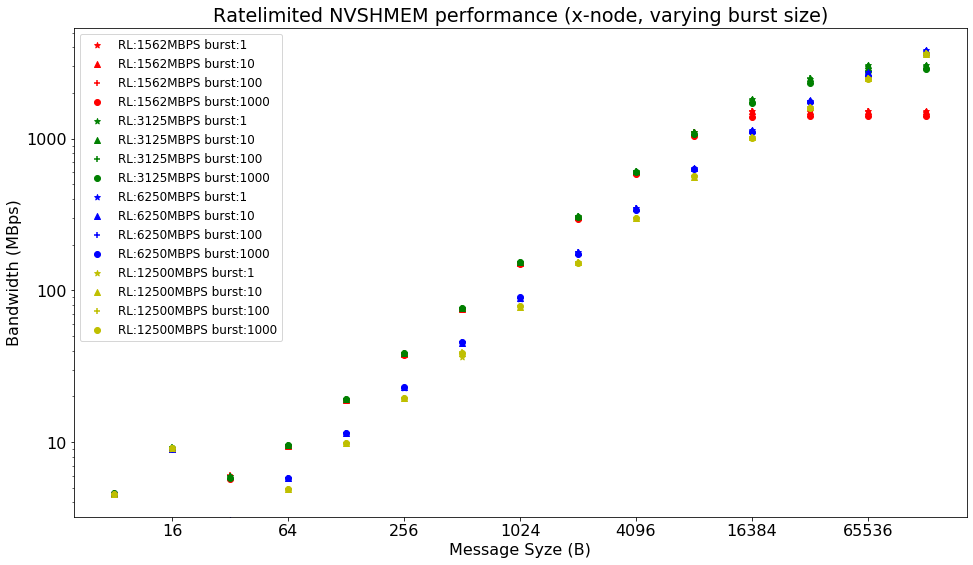

In [64]:
df = xnode
plotdata = {}
df = df.astype({'MsgSize': 'int32', "BurstSize": 'int32'})
#Generate the data
for rl in rls:
    plotdata[rl] = {}
    for bs in df.BurstSize.unique():
        plotdata[rl][bs] = {}
        plotdata[rl][bs]["xs"] = []
        plotdata[rl][bs]["ys"] = []
        for m in msgs:
            dftmp = df[df.MsgSize == m]
            dftmp = dftmp[dftmp.RateLimit == rl]
            vals = dftmp[dftmp.BurstSize == bs].AvgBW.values
            for val in vals:
                plotdata[rl][bs]["ys"] += [float(val)]
                plotdata[rl][bs]["xs"] += [int(m)]
#Plot the data with a color for each ratelimit and shape for each burst size  
fig, ax = plt.subplots(figsize=(16,9))
rlcolors=['r','g','b','y']
rlidx = 0
burstshapes={1000:'o', 100:'+', 10:'^', 1:'*'}
for k in plotdata.keys():
    for bk in plotdata[k].keys():
        print(type(bk))
        ax.scatter(plotdata[k][bk]["xs"][:], plotdata[k][bk]["ys"][:], label="RL:"+ str(k)+ "MBPS"+" burst:{}".format(bk), marker=burstshapes[bk], color=rlcolors[rlidx])
    rlidx += 1
ax.set_xscale('log', basex=2)
ax.set_yscale('log')
from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.legend(fontsize=12)
ax.set_ylabel("Bandwidth (MBps)")
ax.set_xlabel("Message Syze (B)")
ax.set_title("Ratelimited NVSHMEM performance (x-node, varying burst size)\nDevice Control Proc.")
matplotlib.rcParams.update({'font.size': 16})
plt.show()
fig.savefig("nvshmem-device-xnode-ratelimited-bandwidth.png")

And now for the non-rate limited data

In [97]:
mypaths = ["../results/summit/device/standard/nvshmem/02-20-20.14.04.48/nvtests/device/shmem_get_bw.out",
          "../results/summit/host/standard/nvshmem/02-20-20.14.04.48/nvtests/host/bw.out"]

In [98]:
dfs = []
for mypath in mypaths:
    dftmp = pd.DataFrame(extractBandwidthStd(mypath), columns=["MsgSize", "AvgBW"])
    dftmp["RorW"] = "read"
    dftmp["Distance"] = "xnode"
    if "12500" in mypath:
        dftmp["RateLimit"] = 12500
    elif "6250" in mypath:
        dftmp["RateLimit"] = 6250
    elif "3125" in mypath:
        dftmp["RateLimit"] = 3125
    elif "1562" in mypath:
        dftmp["RateLimit"] = 1562
    else:
        print("Ratelimit not detected {}".format(mypath))
    if "host" in mypath:
        dftmp["HorD"] = "host"
    if "device" in mypath:
        dftmp["HorD"] = "device"
    dfs += [dftmp]
df_nv_dev = pd.concat(dfs)

Ratelimit not detected ../results/summit/device/standard/nvshmem/02-20-20.14.04.48/nvtests/device/shmem_get_bw.out
Ratelimit not detected ../results/summit/host/standard/nvshmem/02-20-20.14.04.48/nvtests/host/bw.out


In [99]:
readdata = df_nv_dev[df_nv_dev.RorW == "read"]
xsocket = readdata[readdata.Distance == "xsocket"]
loopback = readdata[readdata.Distance == "loopback"]
xnode = readdata[readdata.Distance == "xnode"]

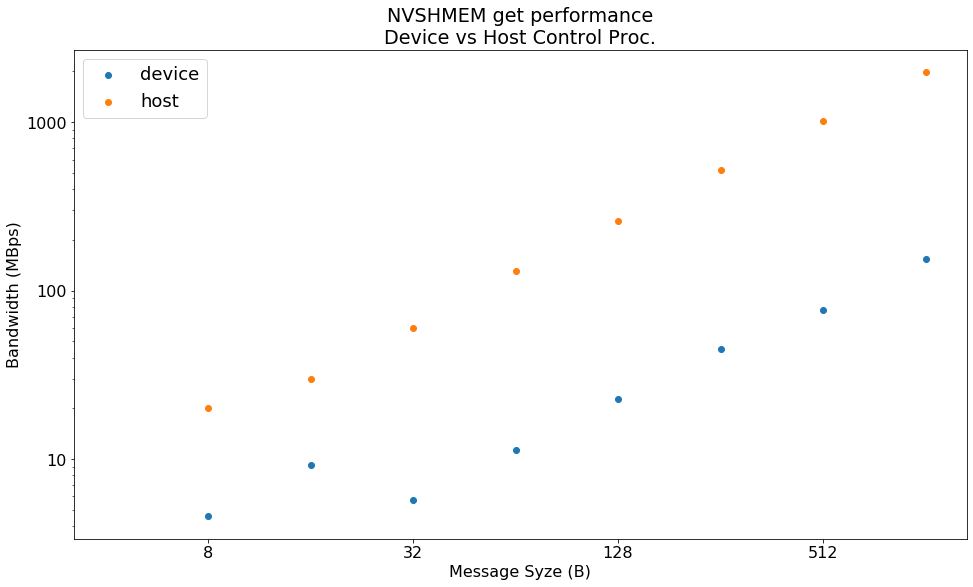

In [138]:
#Generate the data
fig, ax = plt.subplots(figsize=(16,9))
df = xnode[xnode["HorD"]=="device"]
ax.scatter([int(s) for s in df.MsgSize.values[:8]], df.AvgBW.values[:8], label="device")
df = xnode[xnode["HorD"]=="host"]
ax.scatter([int(s) for s in df.MsgSize.values[1:9]], df.AvgBW.values[1:9], label="host")

ax.set_xscale('log', basex=2)
ax.set_yscale('log')
from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.legend(fontsize=18)
ax.set_ylabel("Bandwidth (MBps)")
ax.set_xlabel("Message Syze (B)")
ax.set_title("NVSHMEM get performance\nDevice vs Host Control Proc.")
matplotlib.rcParams.update({'font.size': 16})
plt.show()
fig.savefig("nvshmem-hvsd-xnode-bandwidth-lt1K.png")

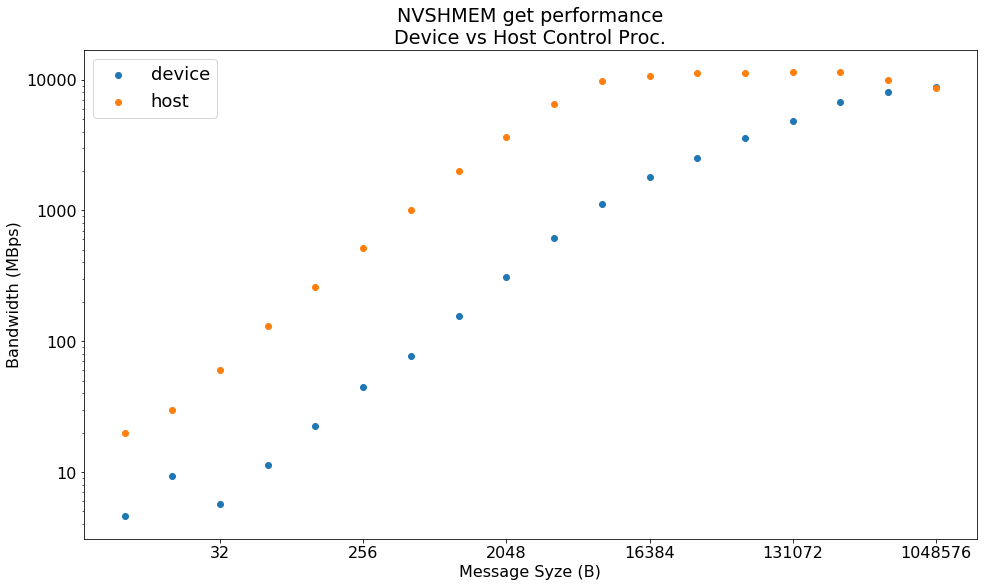

In [172]:
#Generate the data
fig, ax = plt.subplots(figsize=(16,9))
df = xnode[xnode["HorD"]=="device"]
ax.scatter([int(s) for s in df.MsgSize.values[:18]], df.AvgBW.values[:18], label="device")
df = xnode[xnode["HorD"]=="host"]
ax.scatter([int(s) for s in df.MsgSize.values[1:19]], df.AvgBW.values[1:19], label="host")

ax.set_xscale('log', basex=2)
ax.set_yscale('log')
from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.legend(fontsize=18)
ax.set_ylabel("Bandwidth (MBps)")
ax.set_xlabel("Message Syze (B)")
ax.set_title("NVSHMEM get performance\nDevice vs Host Control Proc.")
matplotlib.rcParams.update({'font.size': 16})
plt.show()
fig.savefig("nvshmem-hvsd-xnode-bandwidth.png")

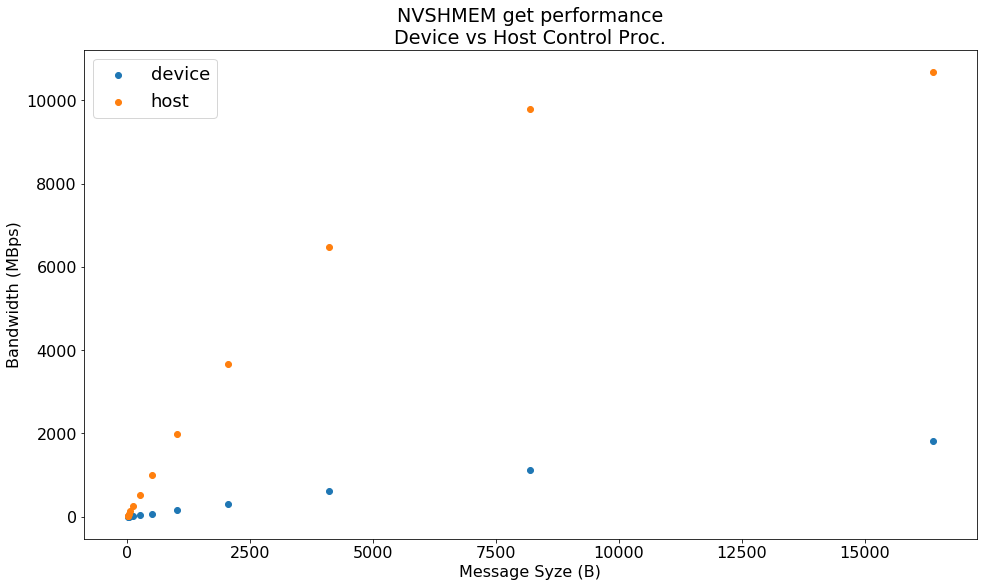

In [155]:
#Generate the data
fig, ax = plt.subplots(figsize=(16,9))
df = xnode[xnode["HorD"]=="device"]
ax.scatter([int(s) for s in df.MsgSize.values[:12]], df.AvgBW.values[:12], label="device")
df = xnode[xnode["HorD"]=="host"]
ax.scatter([int(s) for s in df.MsgSize.values[1:12]], df.AvgBW.values[1:12], label="host")

#ax.set_xscale('log', basex=2)
#ax.set_yscale('log')
from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.legend(fontsize=18)
ax.set_ylabel("Bandwidth (MBps)")
ax.set_xlabel("Message Syze (B)")
ax.set_title("NVSHMEM get performance\nDevice vs Host Control Proc.")
matplotlib.rcParams.update({'font.size': 16})
plt.show()

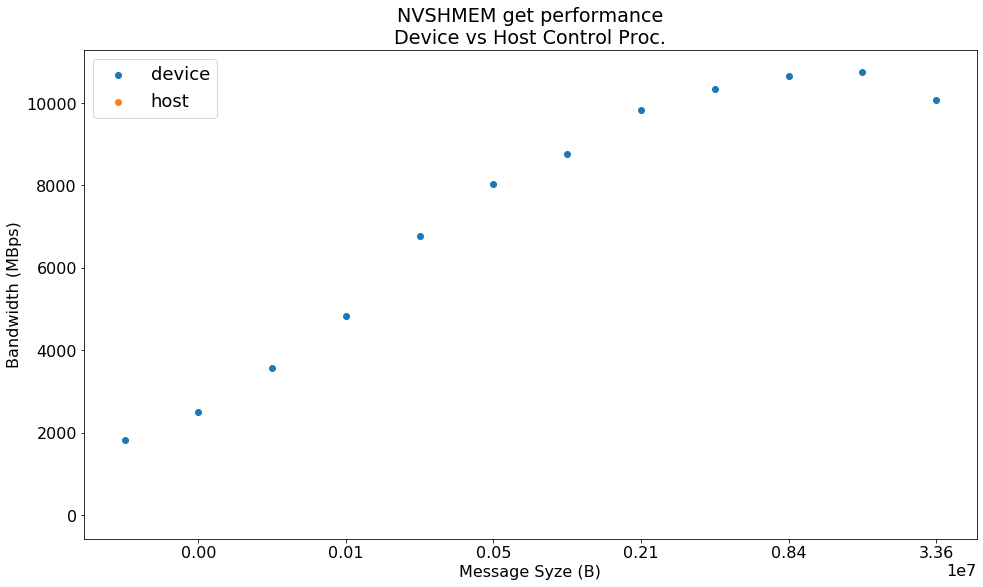

In [177]:
fig, ax = plt.subplots(figsize=(16,9))
df = xnode[xnode["HorD"]=="device"]
dev_xs = [int(s) for s in df.MsgSize.values[11:]]
dev_ys = df.AvgBW.values[11:]
ax.scatter(dev_xs, dev_ys, label="device")
df = xnode[xnode["HorD"]=="host"]
host_xs = [int(s) for s in df.MsgSize.values[1:12]]
host_ys = df.AvgBW.values[1:12]
ax.scatter(host_xs, host_ys, label="host")

ax.set_xscale('log', basex=2)
#ax.set_yscale('log')
from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax.legend(fontsize=18)
ax.set_ylabel("Bandwidth (MBps)")
ax.set_xlabel("Message Syze (B)")
ax.set_title("NVSHMEM get performance\nDevice vs Host Control Proc.")
matplotlib.rcParams.update({'font.size': 16})
plt.show()

In [174]:
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit([[x] for x in dev_xs], [[y] for y in dev_ys])

# The coefficients
print('Coefficients: \n', regr.coef_)
print(regr.intercept_)

regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit([[x] for x in host_xs], [[y] for y in host_ys])

# The coefficients
print('Coefficients: \n', regr.coef_)
print(regr.intercept_)

Coefficients: 
 [[0.13751078]]
[10.48667947]
Coefficients: 
 [[1.24774553]]
[318.81083059]


In [179]:
for x in dev_xs:
    print(x)

16384
32768
65536
131072
262144
524288
1048576
2097152
4194304
8388608
16777216
33554432


In [168]:
host_ys

array([  20.,   30.,   60.,  130.,  260.,  520., 1010., 1990., 3670.,
       6470., 9780.])

In [169]:
dev_ys

array([ 154.58,  309.02,  617.98, 1110.7 , 1812.81, 2507.84, 3578.02,
       4820.1 , 6780.27, 8022.18, 8769.69])

In [171]:
dev_xs == host_xs

True